# Litho facies prediction using well logs

This dataset comes from 10 wells in the Hugoton and Panoma Fields in North America. Each well contains 8 logs as shown below. Among these 8 logs, logs 1-5 are measured or derived logs, 6 and 7 are indicators derived from geological information. The last one **"Facies"** is the interpretated facies by geoscientist based on the logs from 1-7.  
1. GR: this wireline logging tools measure gamma emission
2. ILD_log10: this is resistivity measurement
3. PE: photoelectric effect log. A supplementary measurements from density tool. Less sensitive to porosity than density log, but more sensitive to minerals.
4. DeltaPHI: Phi is a porosity index in petrophysics. Density-neutron porosity difference
5. PNHIND: Average of neutron and density log.
6. NM_M:nonmarine-marine indicator
7. RELPOS: relative position
8. Facies: interpreted litho facies based on logs 1-7.

For the Facies column, there are 9 facies presented as integers in the dataset. The maping is as following:

1. SS: Nonmarine sandstone
2. CSiS: Nonmarine coarse siltstone
3. FSiS: Nonmarine fine siltstone
4. SiSH: Marine siltstone and shale
5. MS: Mudstone (limestone)
6. WS: Wackestone (limestone)
7. D: Dolomite
8. PS: Packstone-grainstone (limestone)
9. BS: Phylloid-algal bafflestone (limestone)

The neighboring facies are somewhat constrained. For example facies 2 Coarse Siltstone is usually
adjacent to facies 1 (Sandstone) or facies 3 (Fine Siltstone).

Key data source: Data source is from Kaggle: https://www.kaggle.com/datasets/imeintanis/well-log-facies-dataset

## 1. Data import and wrangling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### 1.1 Data import

In [2]:
#Import data from the csv file

data = pd.read_csv("facies_vectors.csv")
data.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4149 entries, 0 to 4148
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Facies     4149 non-null   int64  
 1   Formation  4149 non-null   object 
 2   Well Name  4149 non-null   object 
 3   Depth      4149 non-null   float64
 4   GR         4149 non-null   float64
 5   ILD_log10  4149 non-null   float64
 6   DeltaPHI   4149 non-null   float64
 7   PHIND      4149 non-null   float64
 8   PE         3232 non-null   float64
 9   NM_M       4149 non-null   int64  
 10  RELPOS     4149 non-null   float64
dtypes: float64(7), int64(2), object(2)
memory usage: 356.7+ KB


Column 0 Facies is the target feature. 
Column 4 to 8 are the conventional well logs
Column 9 NM_M: the facies is Marine or Nonmarine
Column 10 RELPOS: relative position, 

In [4]:
wellnames = data['Well Name'].unique()
print(wellnames)

['SHRIMPLIN' 'ALEXANDER D' 'SHANKLE' 'LUKE G U' 'KIMZEY A'
 'CROSS H CATTLE' 'NOLAN' 'Recruit F9' 'NEWBY' 'CHURCHMAN BIBLE']


In [5]:
formations = data['Formation'].unique()
print(formations)

['A1 SH' 'A1 LM' 'B1 SH' 'B1 LM' 'B2 SH' 'B2 LM' 'B3 SH' 'B3 LM' 'B4 SH'
 'B4 LM' 'B5 SH' 'B5 LM' 'C SH' 'C LM']


### 1.2 Check if any formation is missing in any well

In [6]:
for well in wellnames :
    missingF = set(formations) - set(data.loc[data['Well Name']==well]['Formation'])
    if len(missingF) > 0:
        print('Well ', well, ' is missing formations: ', missingF)

Well  SHANKLE  is missing formations:  {'B3 LM'}
Well  CROSS H CATTLE  is missing formations:  {'B2 LM', 'B3 LM'}
Well  Recruit F9  is missing formations:  {'B3 SH', 'B2 SH', 'B4 LM', 'B3 LM', 'B4 SH', 'C SH', 'B1 LM', 'B1 SH', 'B5 SH'}
Well  CHURCHMAN BIBLE  is missing formations:  {'B5 SH'}


In [7]:
df = pd.DataFrame(True,index=wellnames,columns=formations)
for well in wellnames:
    flist = set(data.loc[data['Well Name']==well]['Formation'])
    for f in formations:
        if f not in flist :
            df.loc[well][f] = False
df

,A1 SH,A1 LM,B1 SH,B1 LM,B2 SH,B2 LM,B3 SH,B3 LM,B4 SH,B4 LM,B5 SH,B5 LM,C SH,C LM
SHRIMPLIN,True,True,True,True,True,True,True,True,True,True,True,True,True,True
ALEXANDER D,True,True,True,True,True,True,True,True,True,True,True,True,True,True
SHANKLE,True,True,True,True,True,True,True,False,True,True,True,True,True,True
LUKE G U,True,True,True,True,True,True,True,True,True,True,True,True,True,True
KIMZEY A,True,True,True,True,True,True,True,True,True,True,True,True,True,True
CROSS H CATTLE,True,True,True,True,True,False,True,False,True,True,True,True,True,True
NOLAN,True,True,True,True,True,True,True,True,True,True,True,True,True,True
Recruit F9,True,True,False,False,False,True,False,False,False,False,False,True,False,True
NEWBY,True,True,True,True,True,True,True,True,True,True,True,True,True,True
CHURCHMAN BIBLE,True,True,True,True,True,True,True,True,True,True,False,True,True,True


### 1.3 Check for null data

In [8]:
data.isnull().sum()

Facies         0
Formation      0
Well Name      0
Depth          0
GR             0
ILD_log10      0
DeltaPHI       0
PHIND          0
PE           917
NM_M           0
RELPOS         0
dtype: int64

A quick look shows missing data occur only in PE log. Let's find out which well(s) are missing PE data

In [9]:
#check if any log curve is missing from any well
lognames = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS']

for well in wellnames:
    for log in lognames:
        missinglog = data.loc[data['Well Name'] == well][log].isnull().sum()
        
        #print the wells that are missing an entire log curve
        if missinglog == data.value_counts('Well Name')[well]:
            print('Log ', log, ' is missing in well ', well)

Log  PE  is missing in well  ALEXANDER D
Log  PE  is missing in well  KIMZEY A


#### Later in sesstion 2.1 we will deal with the null data ####

### 1.4 Visualize data

In [10]:
# set up color map for facies as a dictionary
facies_cmap = {1: '#FFF68F',
               2: '#8B7500', 
               3: '#FFD700', 
               4: '#8B8386', 
               5: '#5E5E5E', 
               6: '#8B8970', 
               7: '#8B3A62', 
               8: '#CDCDB4', 
               9: '#8B7765'}

In [11]:
# subset for each well
shrimplin = data.loc[data['Well Name']=='SHRIMPLIN']
alexander_d = data.loc[data['Well Name']=='ALEXANDER D']
shankle = data.loc[data['Well Name']=='SHANKLE']
luke_g_u = data.loc[data['Well Name']=='LUKE G U']
kimzey_a = data.loc[data['Well Name']=='KIMZEY A']
cross_h_cattle = data.loc[data['Well Name']=='CROSS H CATTLE']
nolan = data.loc[data['Well Name']=='NOLAN']
recruite_f9 = data.loc[data['Well Name']=='Recruit F9']
newby = data.loc[data['Well Name']=='NEWBY']
churchman_bible = data.loc[data['Well Name']=='CHURCHMAN BIBLE']

In [12]:
loglist = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'Facies']
dflist = [shrimplin,alexander_d,shankle,luke_g_u,kimzey_a,cross_h_cattle,nolan,recruite_f9,newby,churchman_bible]

In [13]:
def displayLogs(df, wellname, lognames, cmap):
    fig, axes = plt.subplots(1, len(lognames), figsize=(20,10), sharey=True)
    
    for i, log in enumerate(lognames):
        if log!= 'Facies':
            axes[i].plot(log, 'Depth', data=df, color=cmap[i])
            axes[i].set_xlabel(log, fontsize=20)
            axes[i].tick_params(labelsize=15)
            axes[i].grid()
        else:
            for key in facies_cmap.keys():
                axes[i].fill_betweenx(df['Depth'], 0, 1, 
                      where=(df['Facies']==key),
                      facecolor=facies_cmap[key])
            axes[i].set_xlabel(log, fontsize=20)
    axes[0].invert_yaxis()
    fig.suptitle(wellname, fontsize=30)

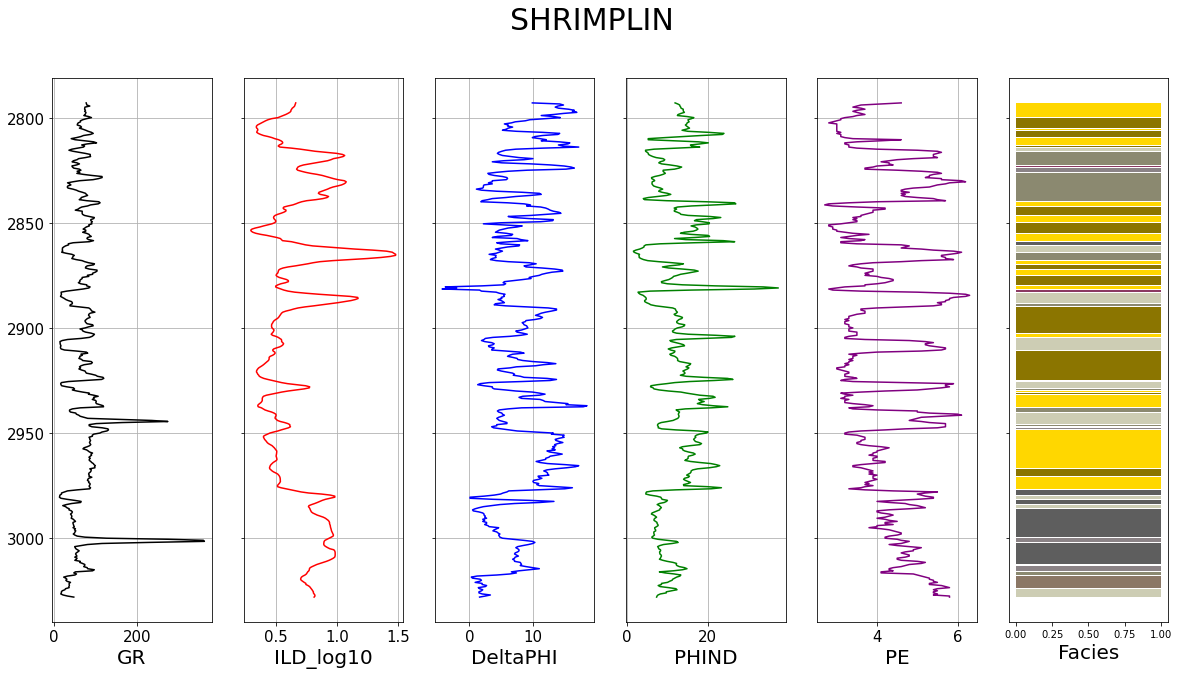

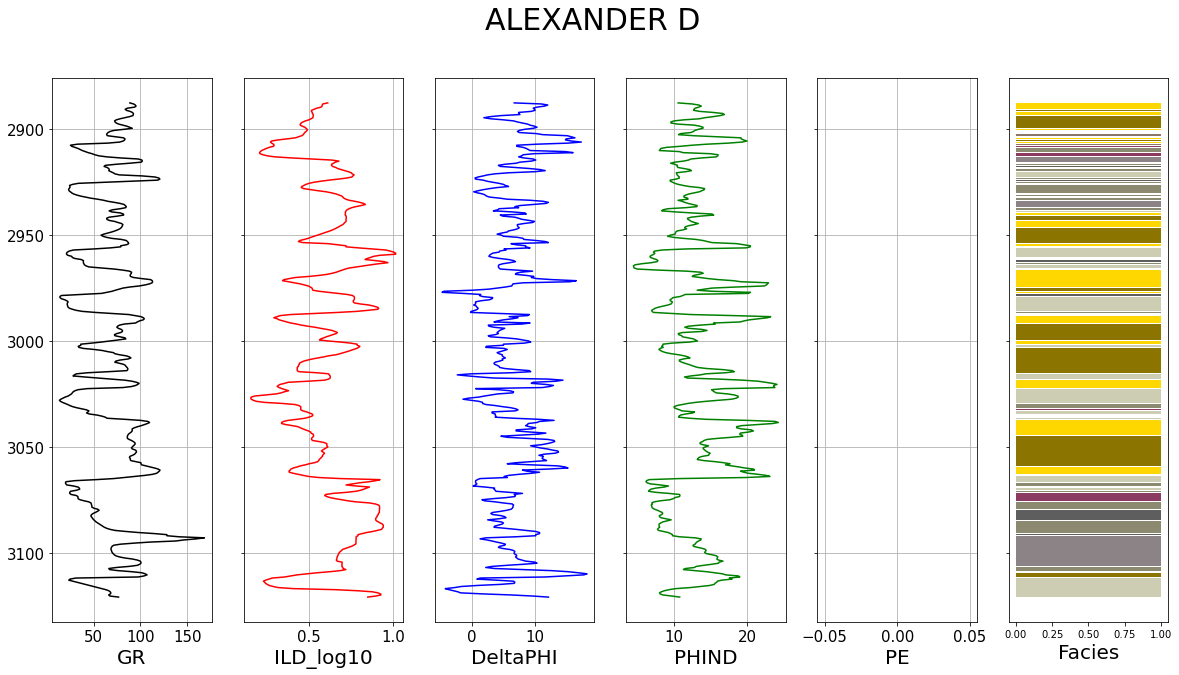

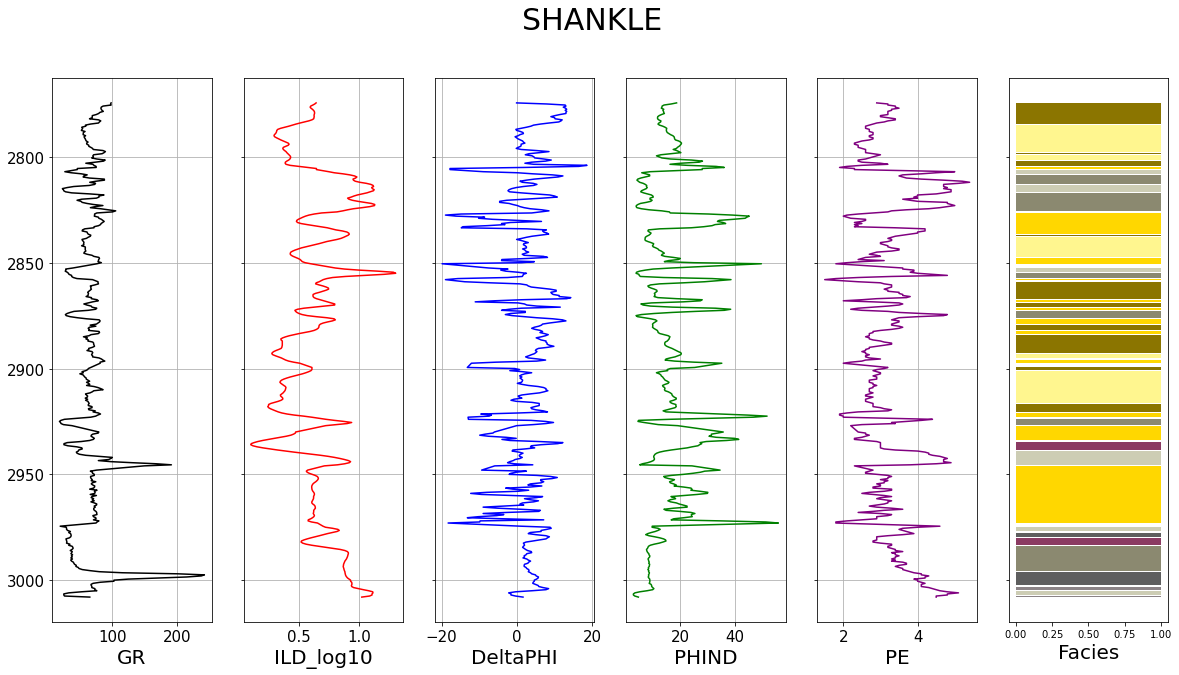

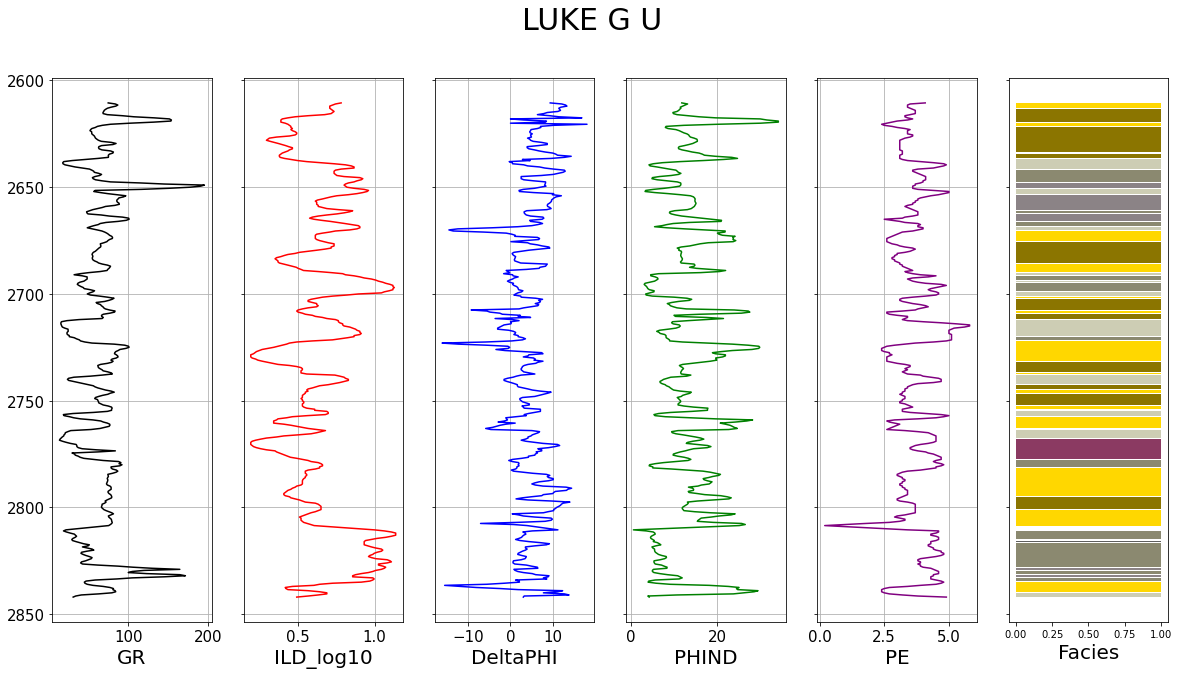

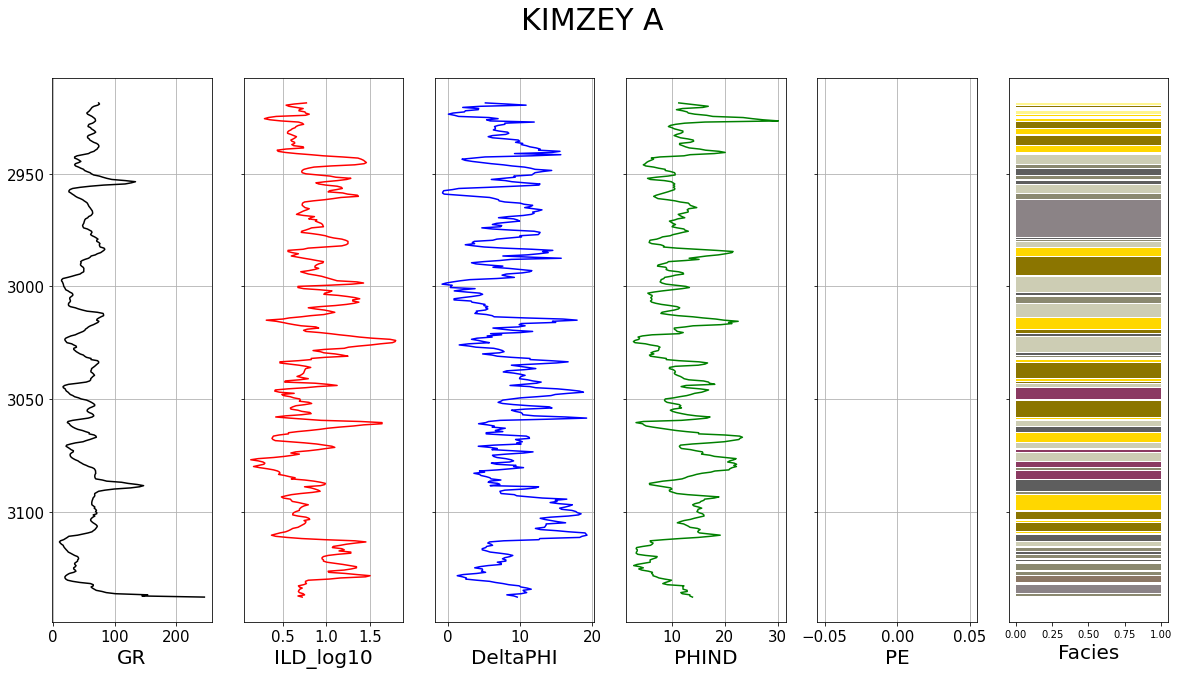

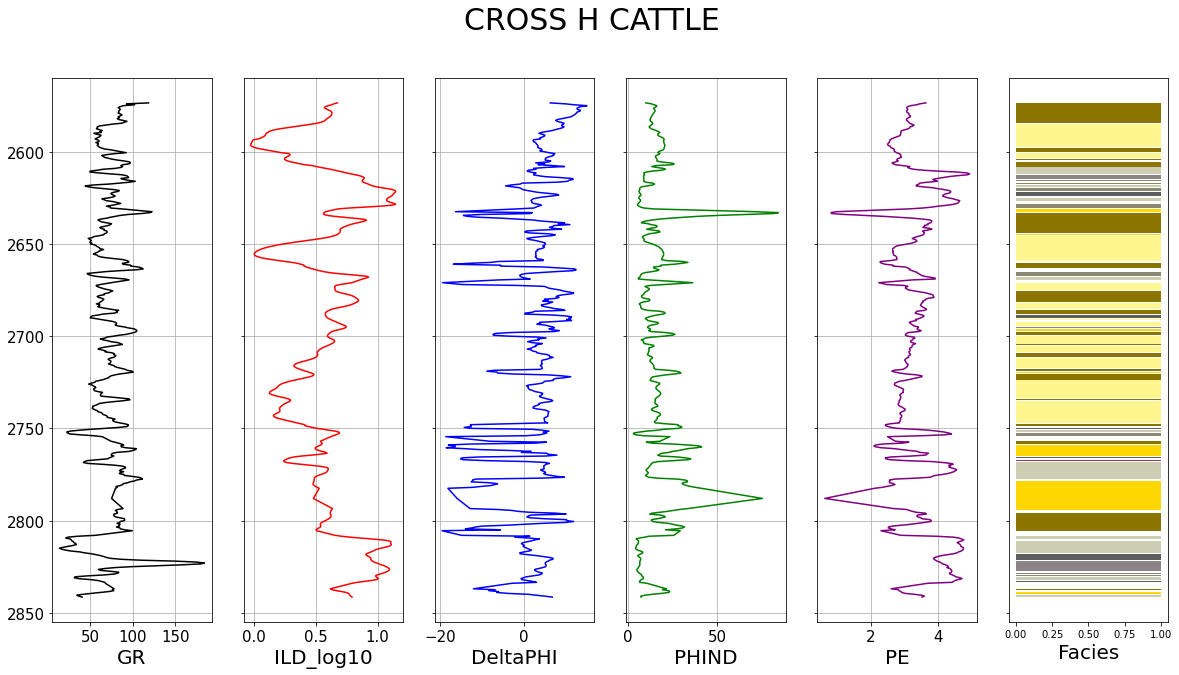

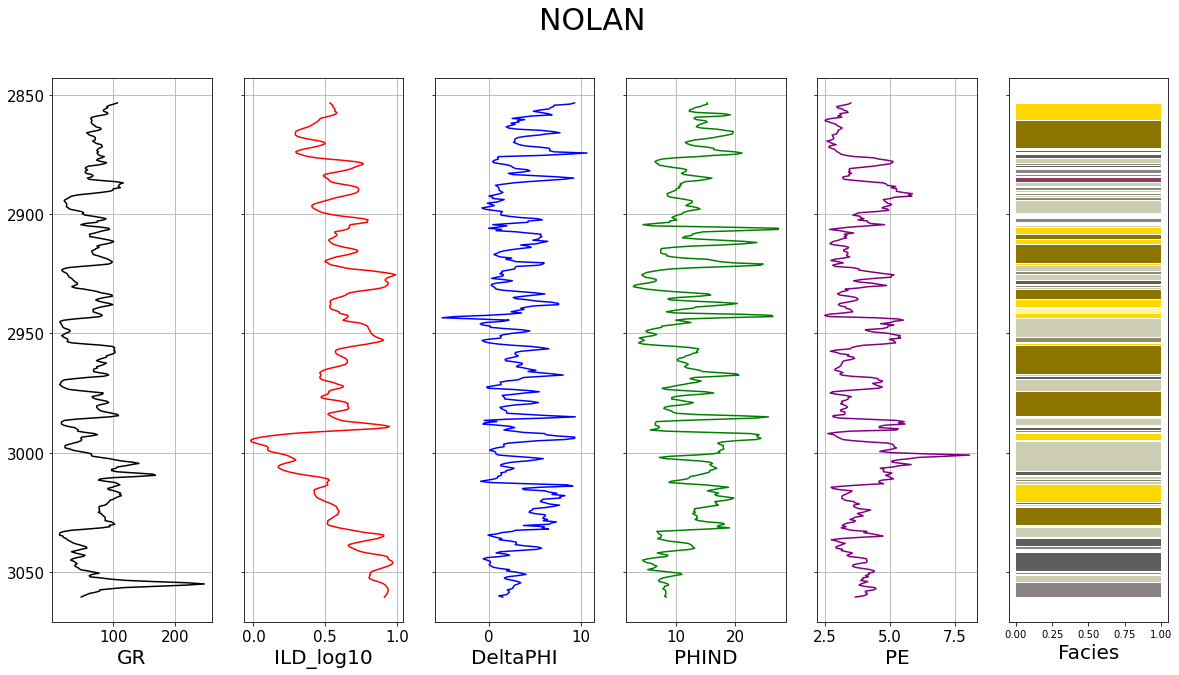

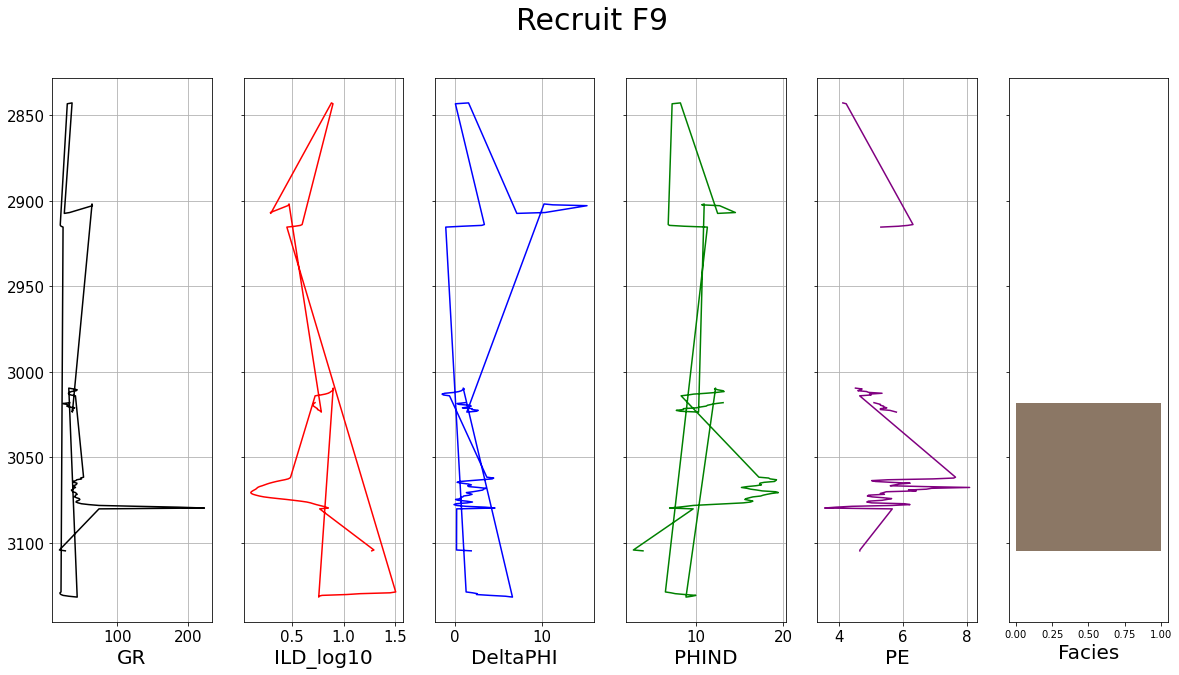

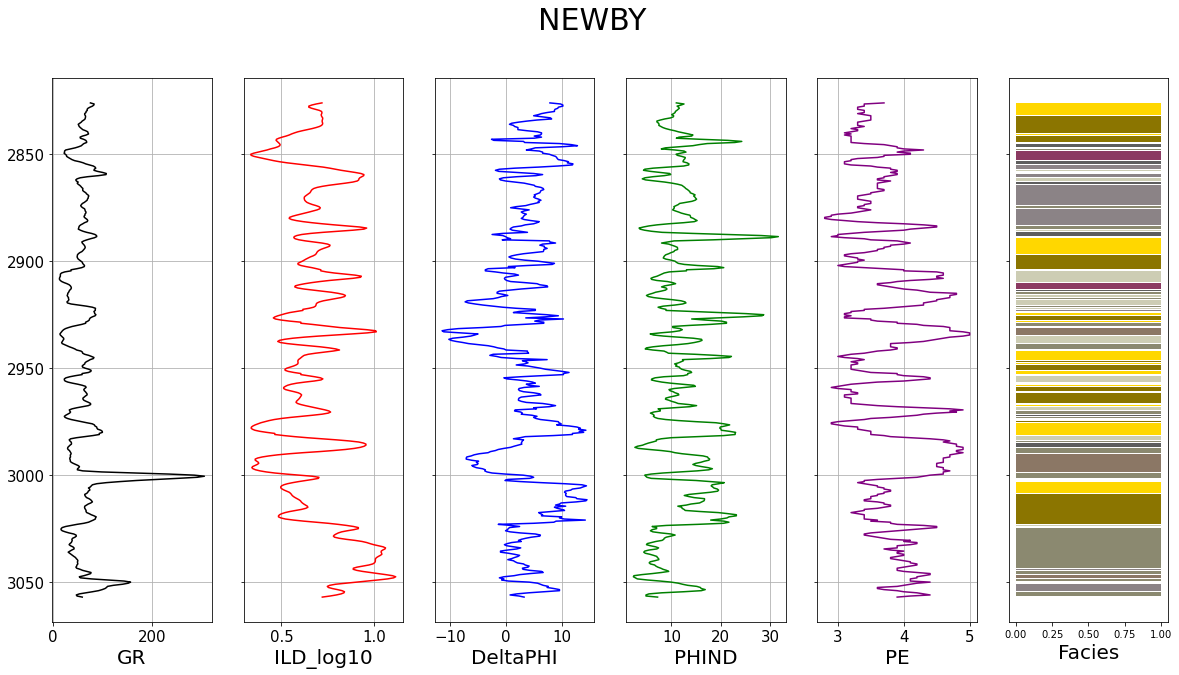

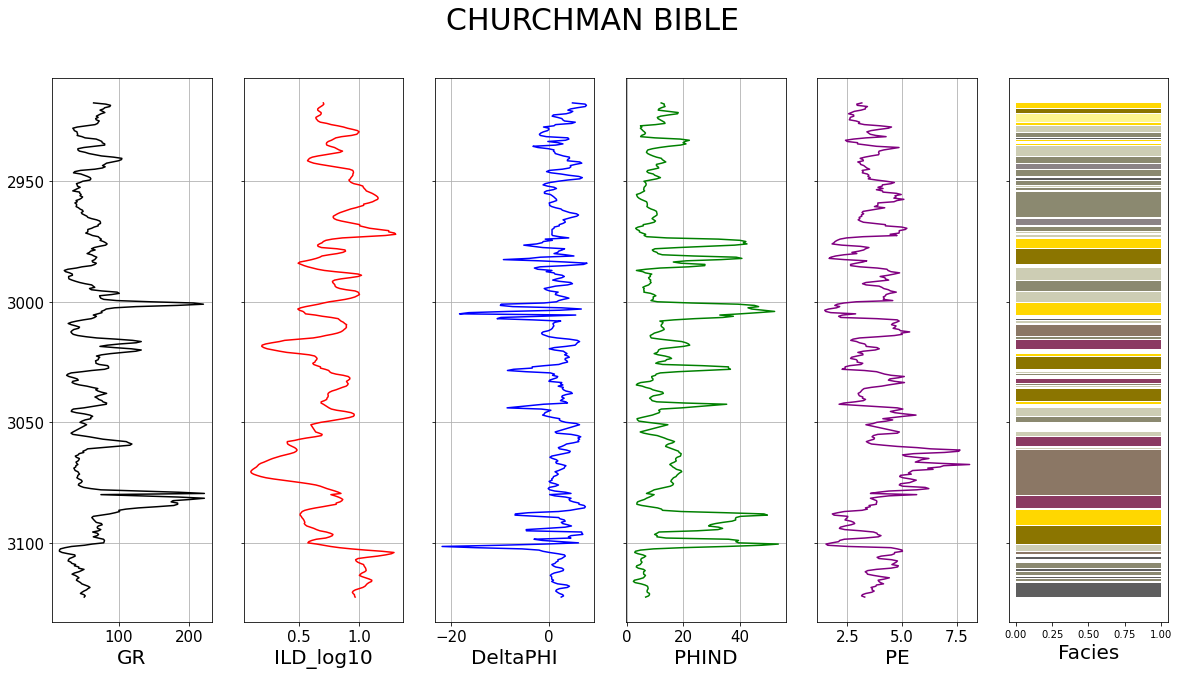

In [14]:
# display logs for each well
log_names = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'Facies']
colormap = ['black', 'red', 'blue', 'green', 'purple']
for df in dflist:
    well_name = df['Well Name'].unique()[0]
    displayLogs(df, well_name, log_names, colormap)

From the plots we can see that Well Recruit F9 looks very suspicious. We will drop this well in its entirety. The other wells look normal except that PE log is missing in two wells 'ALEXANDER D' AND 'KIMZEY A'. We will handle the missing data in session 2.
Now let's remove well 'Recruit F9'.

In [15]:
# Remove well "Recruit F9"
data = data.loc[data['Well Name'] != 'Recruit F9']

wellnames = np.delete(wellnames, np.where(wellnames == 'Recruit F9'))
dflist = [shrimplin,alexander_d,shankle,luke_g_u,kimzey_a,cross_h_cattle,nolan,newby,churchman_bible]

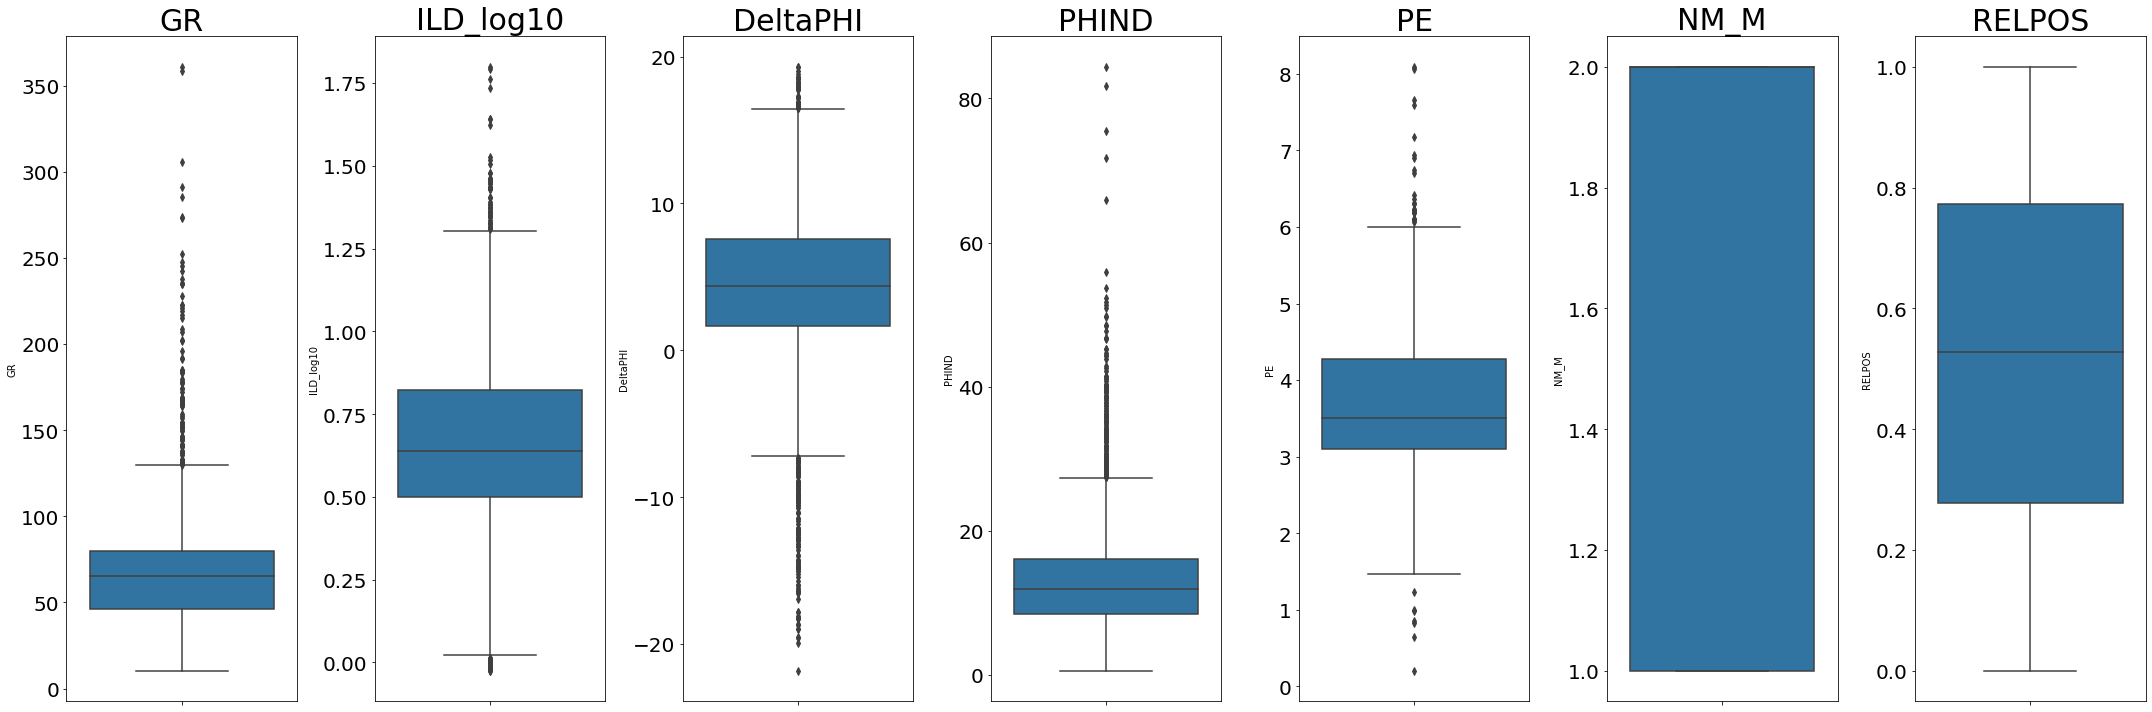

In [16]:
# Make boxplot for each log curve
fig, axes = plt.subplots(1, len(lognames), figsize=(30,10))
for i, ax in enumerate(axes.flat):
    sns.boxplot(data=data, y=data.iloc[:,i+4], ax=axes[i], orient='v')
    ax.set_title(data.columns[i+4], fontsize=30)
    ax.tick_params(axis='y', labelsize = 20)
plt.tight_layout()

All 5 logs are showing some outliers. But the outliers are not necessarily bad data. Let's make the box plots for each well to check if any of the wells have "bad" data.

In [17]:
#plot each log curve to find where the outliers occur

def log_boxplot(welldfs, welllist, log):
    fig, axes = plt.subplots(1, len(welldfs), figsize=(30,10))
    for i, ax in enumerate(axes.flat):
        sns.boxplot(data=welldfs[i], y=log, ax=axes[i], orient='v')
        ax.set_title(log, fontsize=30)
        ax.set_xlabel(welllist[i], fontsize=20)
        ax.tick_params(axis='both', labelsize = 20)
    plt.tight_layout()


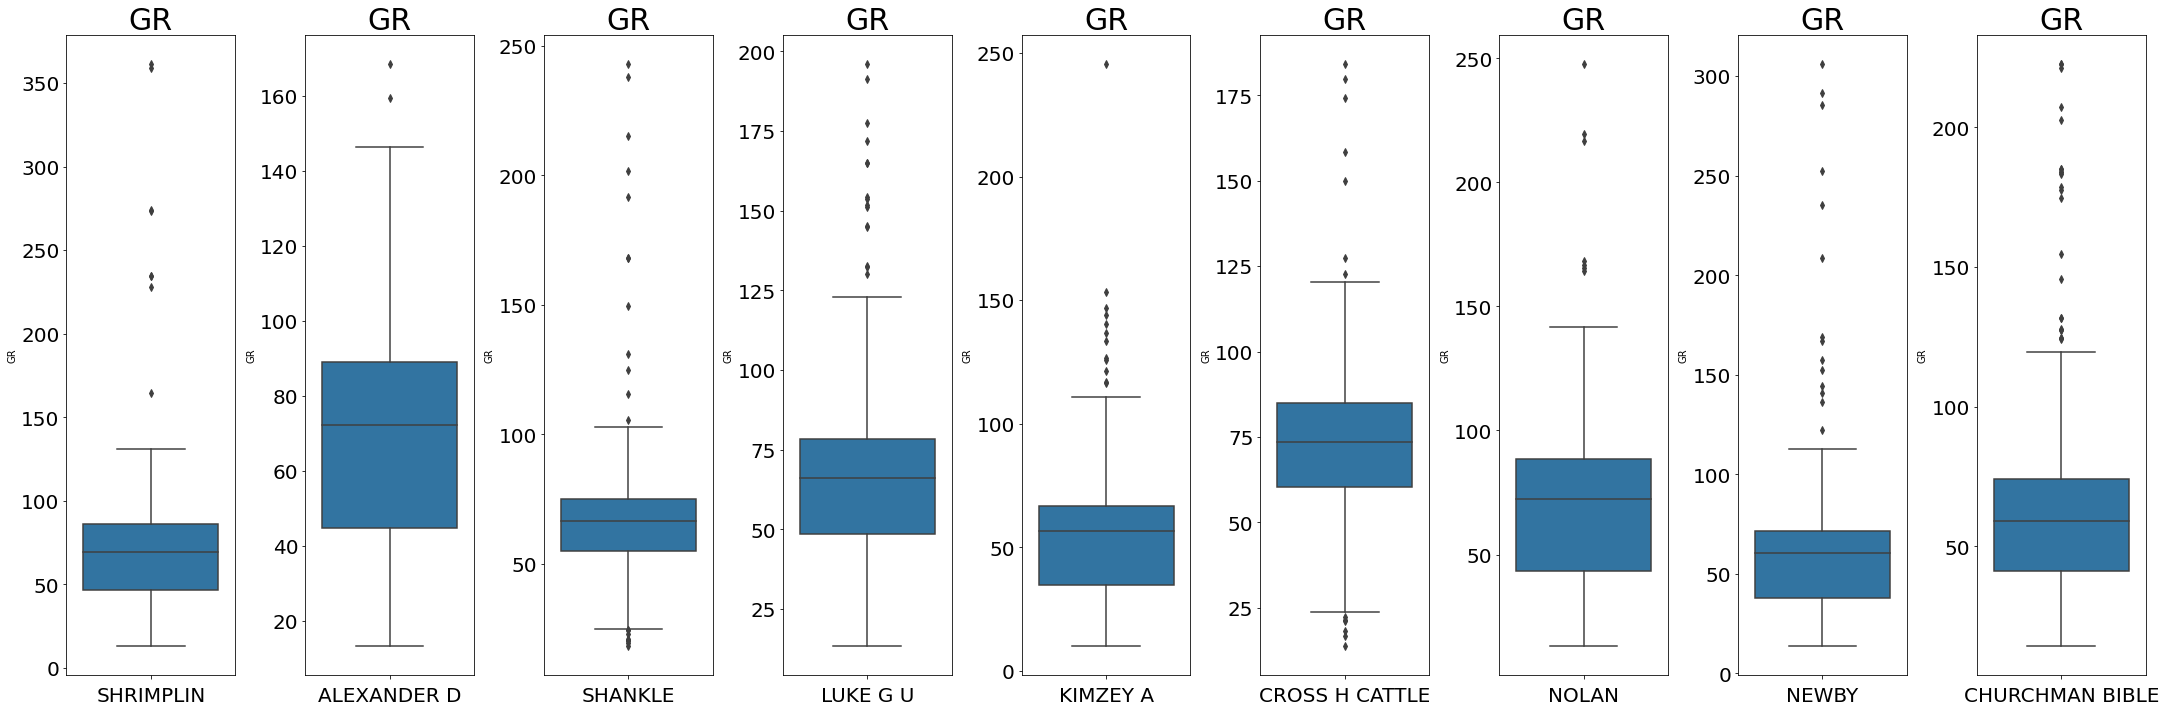

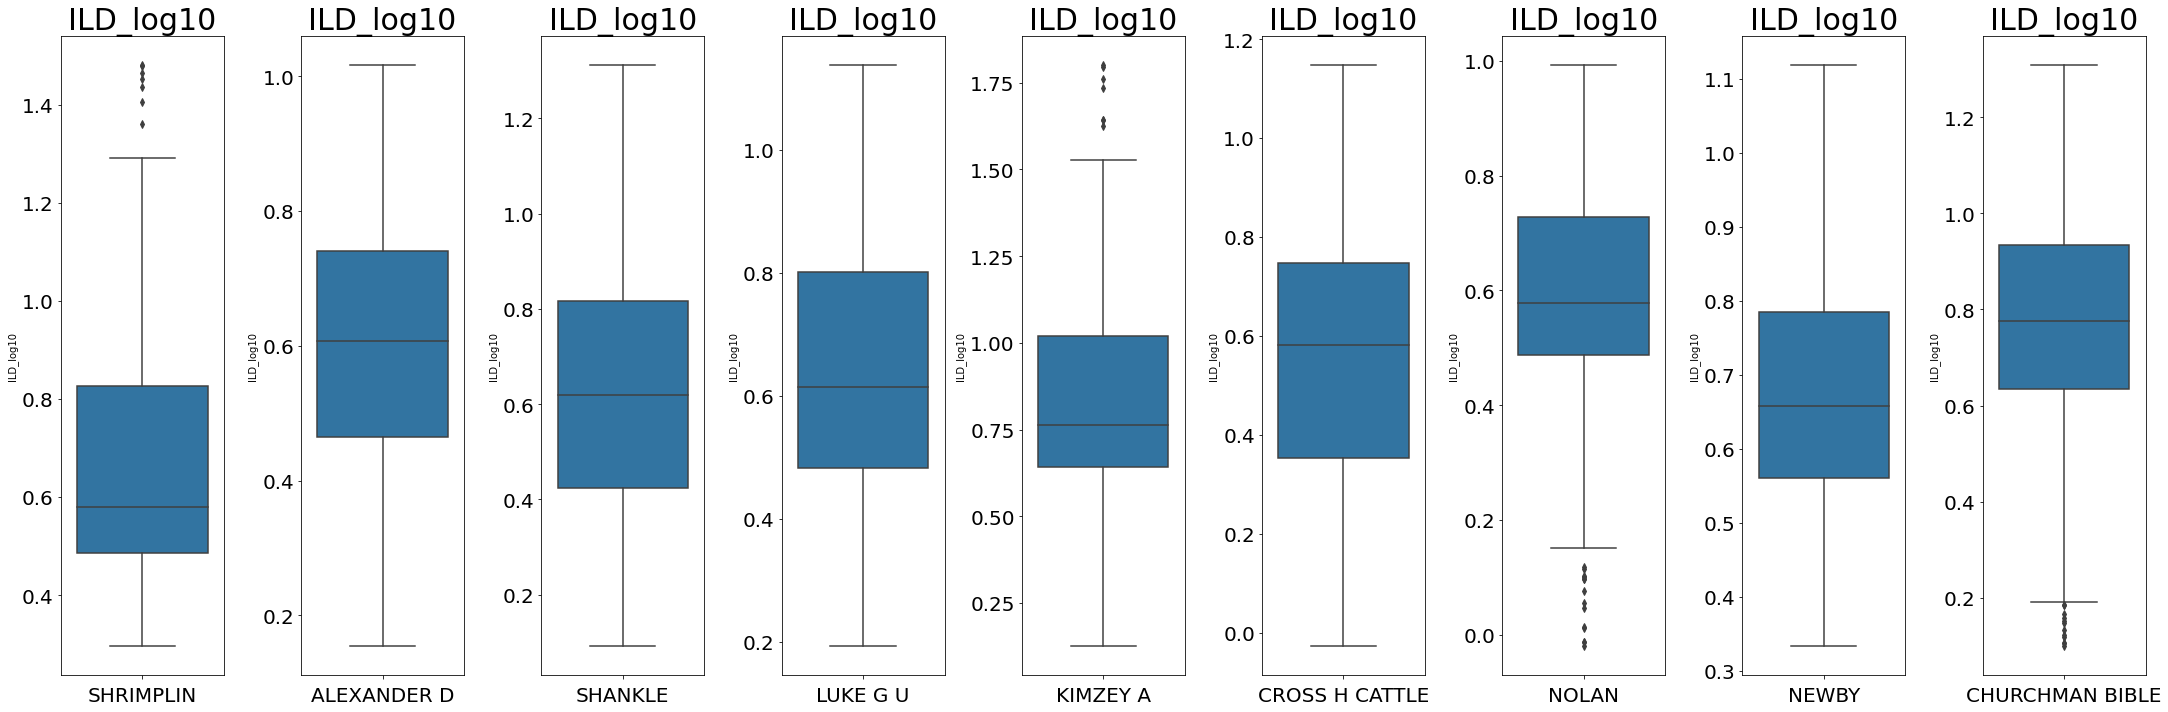

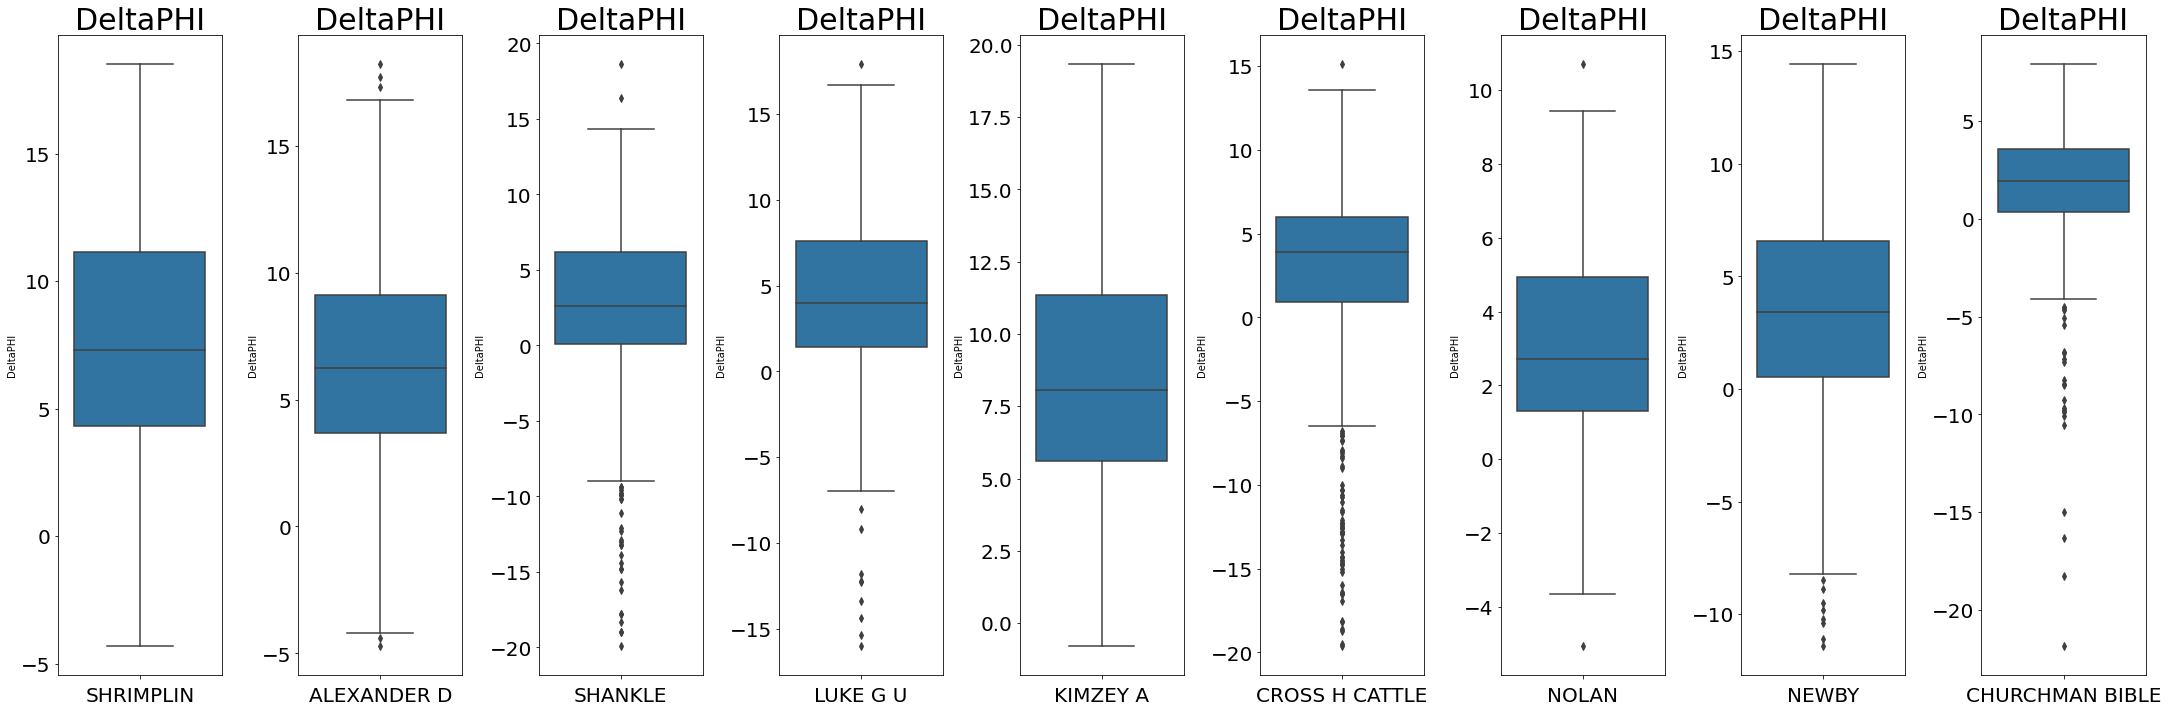

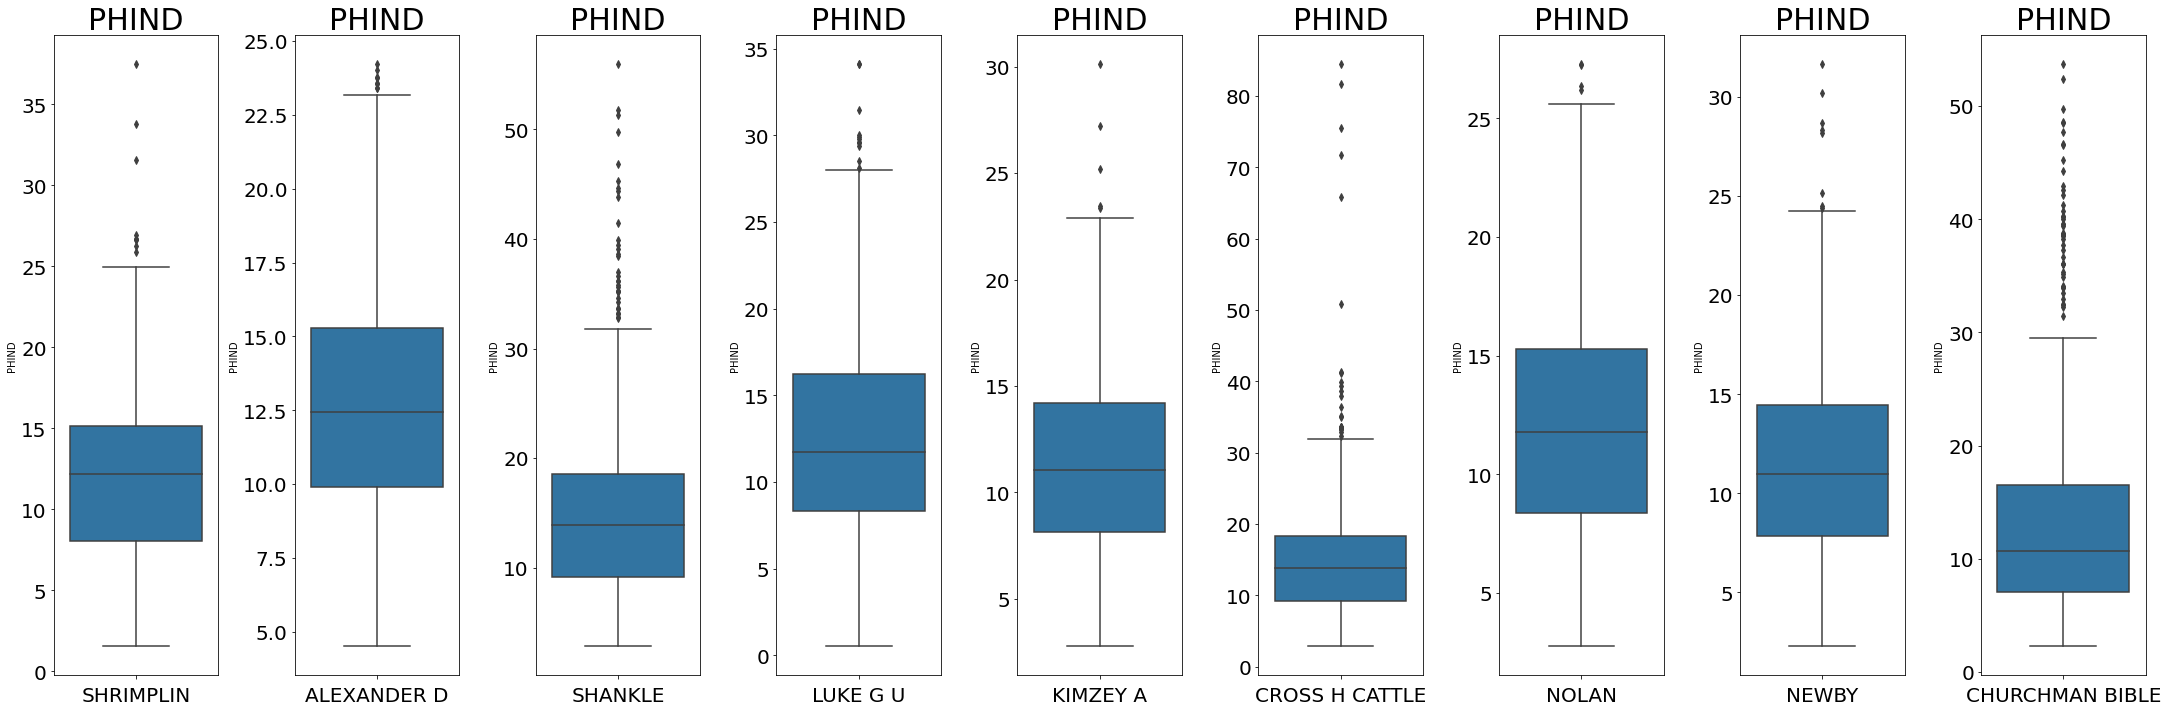

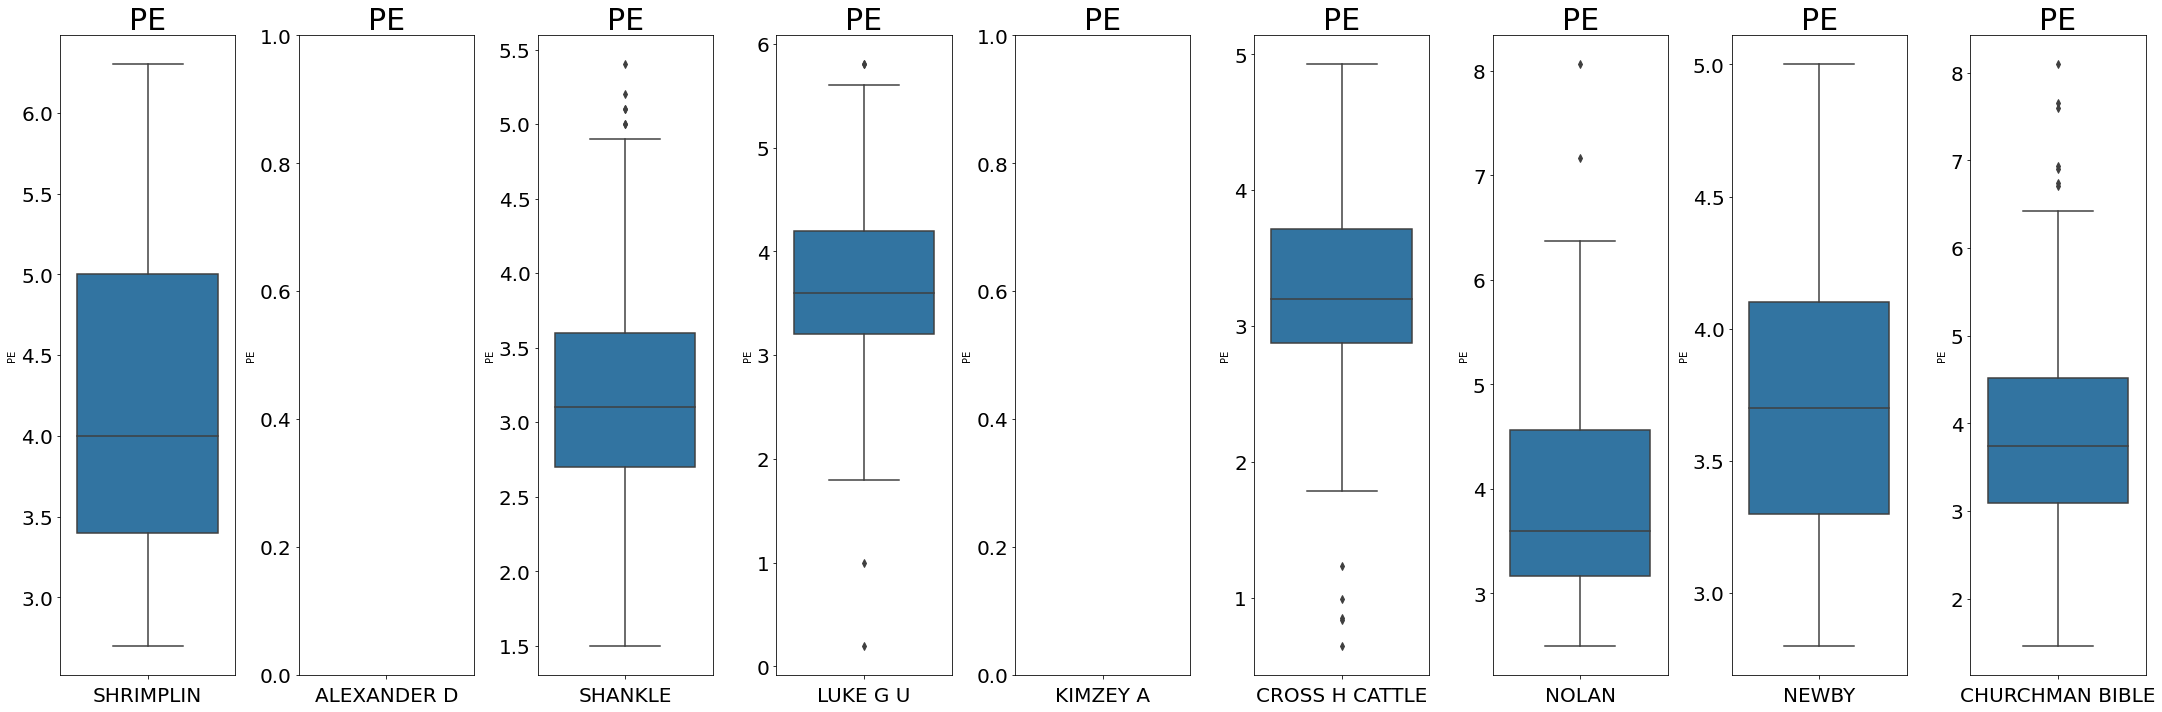

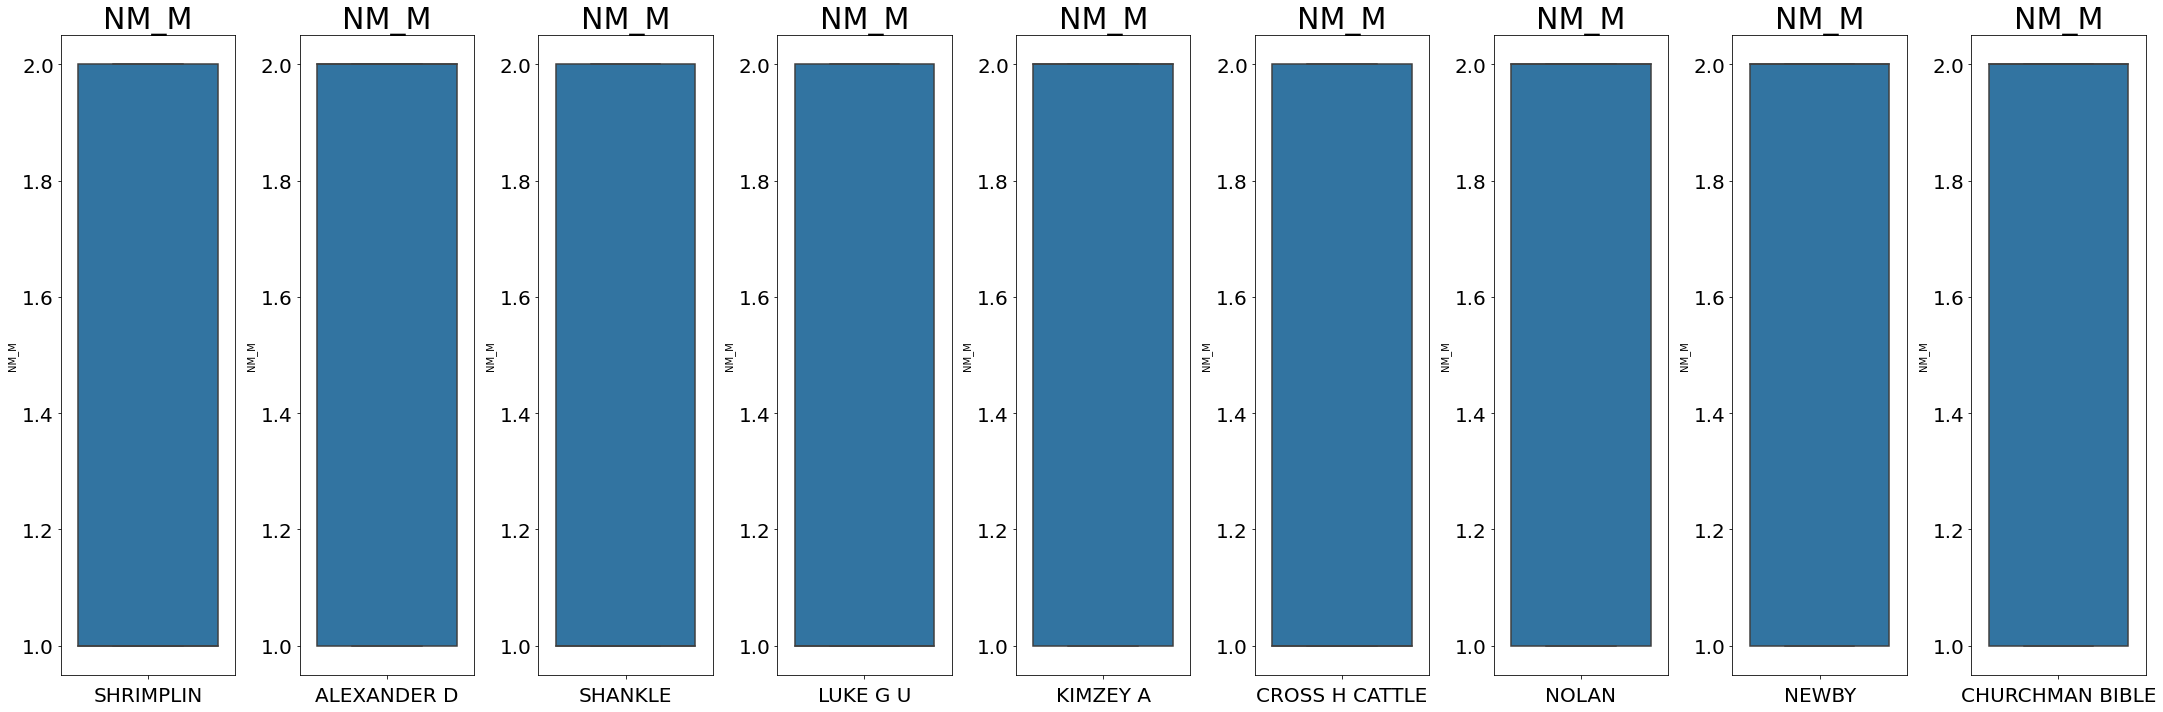

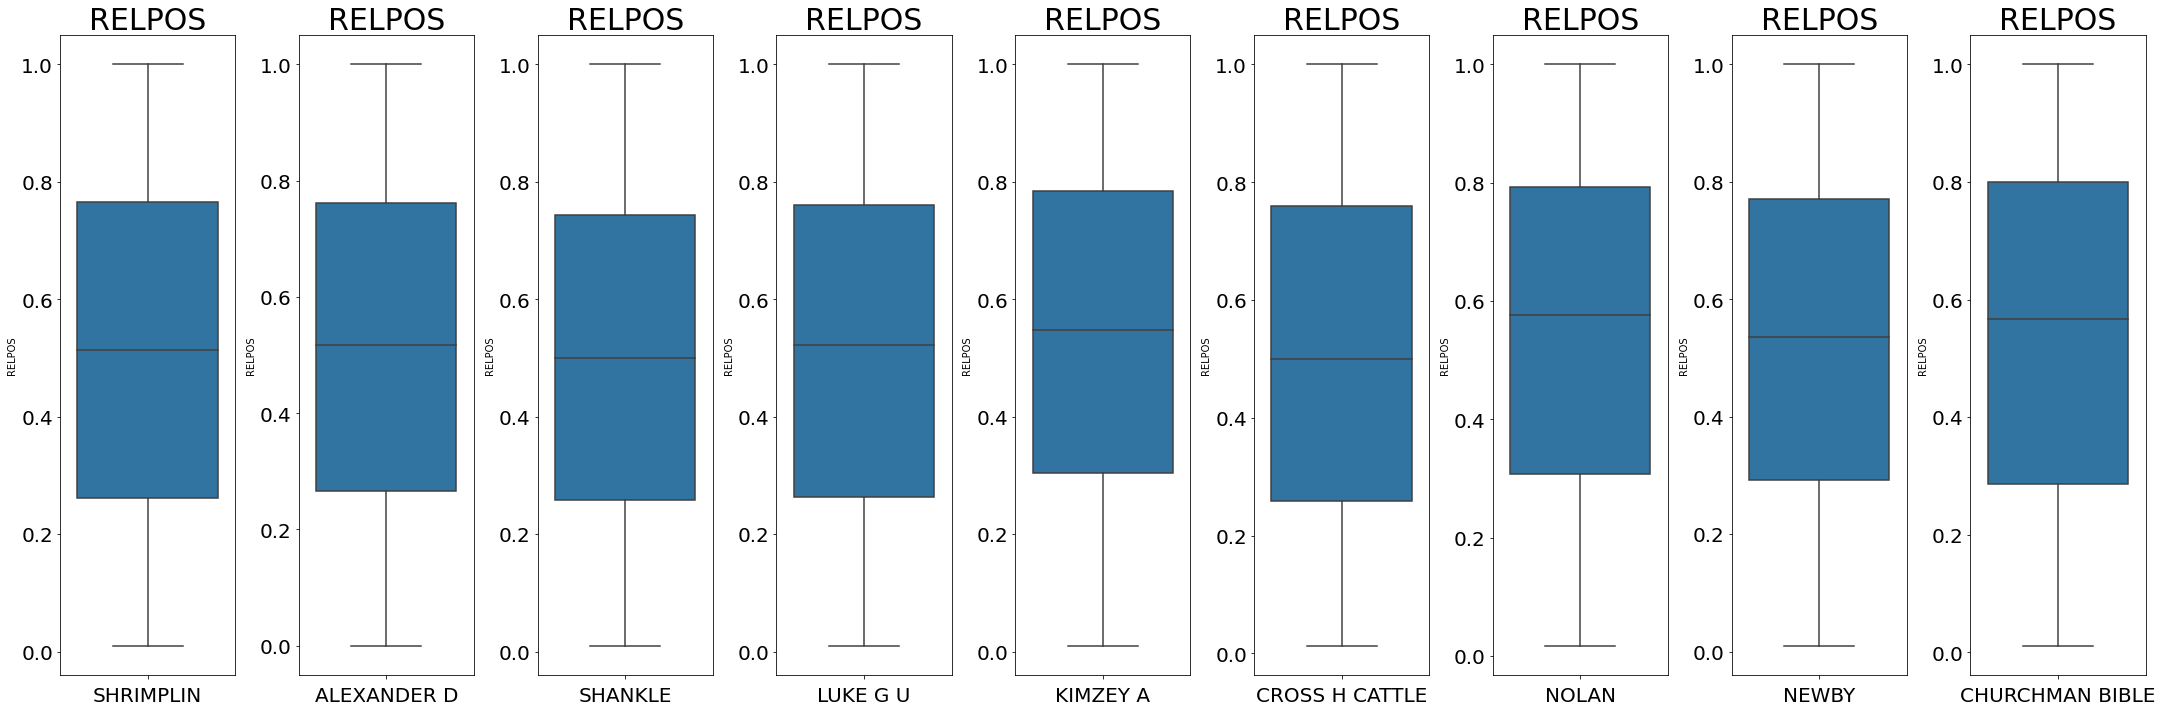

In [18]:
for log in lognames:    
    log_boxplot(dflist, wellnames, log)

From the boxplots, we can see that most of the log curves are in good shape. In the next section, we will experiment data imputation for the missing PE curves.

# 2 Exploratory Data Analysis

PE is missing in two wells. We have two choices: drop these two wells in their entirety, or, we can try to estimate PE from other logs. If we drop these two wells we will lose 22% of the data which is significant. So in this case we would prefer estimating PE if possible. Now let's first plot the correlation between PE and the other logs and see if we can observe any pattern.

## 2.1 Explore relationship between PE and other logs

In [19]:
logdata = data[['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE']]
logdata.head()

,GR,ILD_log10,DeltaPHI,PHIND,PE
0,77.45,0.664,9.9,11.915,4.6
1,78.26,0.661,14.2,12.565,4.1
2,79.05,0.658,14.8,13.050,3.6
3,86.10,0.655,13.9,13.115,3.5
4,74.58,0.647,13.5,13.300,3.4


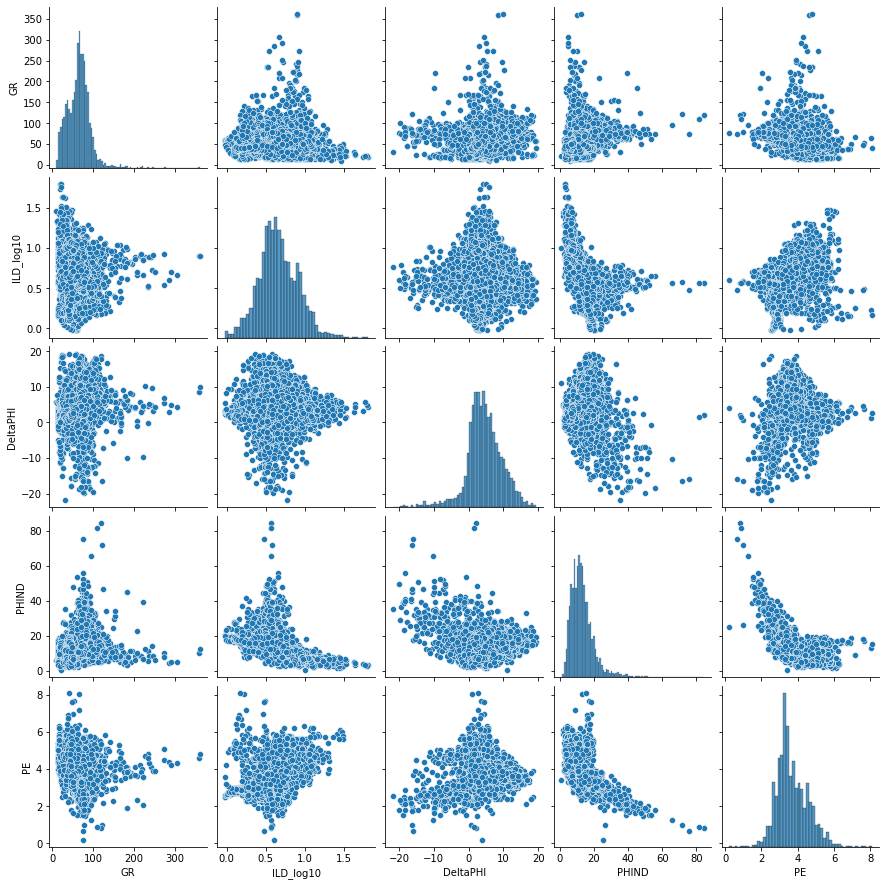

In [20]:
# we will use pairplot and heatmap to examine the correlation between the log curves, 
# especially between PE and other logs.
sns.pairplot(logdata)

<AxesSubplot:>

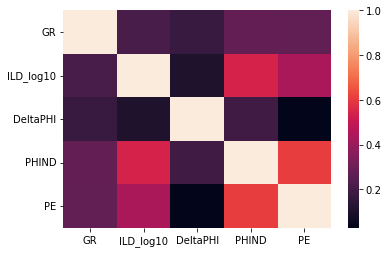

In [21]:
sns.heatmap(np.abs(logdata.corr()))

From the scatter plots and heatmap we see a good correlation between PE and PHIND. We will try to estimate PE from PHIND.

## 2.2 Estimate missing PE for wells "Alexander D" and "Kimzey A"

We will try to estimate PE using the following two methods:
1. **Polynomial regression** using only one log "PHIND"
2. **Netural network multi-layer regression** using all columns including Formation 

### 2.2.1 Polynomial Regression using PHIND

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics

In [23]:
PHIND = data.loc[(data['Well Name'] != 'ALEXANDER D') & (data['Well Name'] != 'KIMZEY A'),'PHIND']
PE = data.loc[:, 'PE'].dropna()
print(PHIND.shape)
print(PE.shape)

(3164,)
(3164,)


In [24]:
X_train, X_test, y_train, y_test = train_test_split(PHIND, PE, test_size=0.3, random_state=101)

In [25]:
X_train=pd.DataFrame(X_train)
y_train=pd.DataFrame(y_train)

X_test=pd.DataFrame(X_train)
y_test=pd.DataFrame(y_train)

In [26]:
poly = PolynomialFeatures(degree=5, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
poly_reg_model = LinearRegression()
poly_reg_model.fit(X_train_poly, y_train)
y_selfpredict_poly = poly_reg_model.predict(X_train_poly)

In [27]:
def calculate_error(real, predict):
    print('MAE:', metrics.mean_absolute_error(real, predict))
    print('MSE:', metrics.mean_squared_error(real, predict))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(real, predict)))
    

In [28]:
calculate_error(y_train, y_selfpredict_poly)
print('R2 score: ', poly_reg_model.score(X_train_poly,y_train))

MAE: 0.49291367934018543
MSE: 0.43966172707745216
RMSE: 0.6630699262351235
R2 score:  0.38605263196822315


In [29]:
def check_scatterplot(x, y, xlabel, ylabel, title):
    plt.scatter(x, y, s=20)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.plot(y, y, color='red')

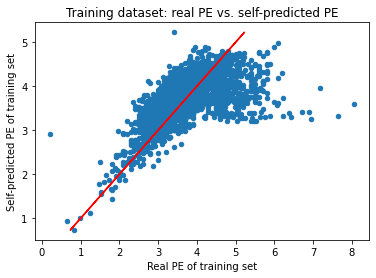

In [30]:
#plot the train split (blue dots) and the predicted y of the X_train
check_scatterplot(y_train,
                  y_selfpredict_poly, 
                  'Real PE of training set', 
                  'Self-predicted PE of training set',
                  'Training dataset: real PE vs. self-predicted PE')

Summary of polynomial regression:
1. MSE is 0.44, R2 score is 0.38. Not a good model because it explains less than half of the data.
2. The scatterplot shows there are a lot of predicted PE data points that don't match the real data.

### 2.2.2 Use Neural Network Multi-layer Regression with the whole suite of logs 

Even though there is no obvious correlation between PE and the logs other than PHIND, we'll still try to use all logs to predict PE, and compare its performance with the polynomial model.

In [31]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

In [32]:
data.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915


In [33]:
# first let's convert formation tops to integers so that we can also use this information 
formations = set(data['Formation'])
fdic={}
for i, top in enumerate(formations):
    fdic[top] = i
    
data = data.replace({'Formation': fdic})
data.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,6,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,6,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,6,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,3,6,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,3,6,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915


In [34]:
LOGS = data.loc[(data['Well Name'] != 'ALEXANDER D') & (data['Well Name'] != 'KIMZEY A'),
                   ['Facies', 'Formation', 'Depth', 'GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'NM_M', 'RELPOS']]
PE = data.loc[:, 'PE']
PE.dropna(inplace=True)
print(LOGS.shape)
print(PE.shape)

(3164, 9)
(3164,)


In [35]:
# scale the data
scaler = StandardScaler()
LOGS = scaler.fit_transform(LOGS)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(LOGS, PE, test_size=0.3, random_state=101)

In [37]:
NNmodel = MLPRegressor()
NNmodel.fit(X_train, y_train)
y_predict_NN = NNmodel.predict(X_train)

C:\Users\hyuan\anaconda3\envs\myenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [38]:
NNmodel.score(X_train, y_train) # examine accuracy

0.7797761082048522

In [39]:
calculate_error(y_train, y_predict_NN)

MAE: 0.28356411379967217
MSE: 0.15770735677355516
RMSE: 0.397123855709469


The Neural Network Multi-layer regressor produces a better performance than polynomial regression model (MSE 0.16 vs. 0.44). Its accuracy is 0.77.

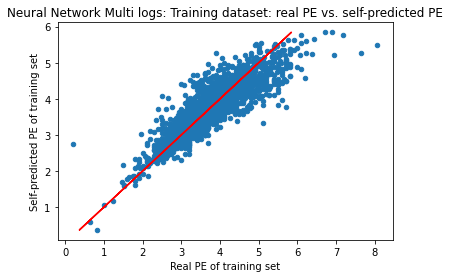

In [40]:
#plot the train split (blue dots) and the predicted y of the X_train
check_scatterplot(y_train,
                  y_predict_NN, 
                  'Real PE of training set', 
                  'Self-predicted PE of training set',
                  'Neural Network Multi logs: Training dataset: real PE vs. self-predicted PE')

The scatter plot also demonstrates a better fit for the training set comparing to the polynomial regression model. Now let's apply the NN model to the test set. 

In [41]:
NNmodel.predict(X_test)
NNmodel.score(X_test, y_test) # examine accuracy

0.7723500844552348

We get similar accuracy with the test data set - a consistent performance. Net step we will use this model to estimate PE log for those two wells.

In [44]:
# well Amexander D
Alex = data.loc[(data['Well Name'] == 'ALEXANDER D'),
                   ['Facies', 'Formation', 'Depth', 'GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'NM_M', 'RELPOS']]
scaler = StandardScaler()
Alex = scaler.fit_transform(Alex)
Alex_PE_predict = NNmodel.predict(Alex)

In [45]:
# well Kimzey A
Kimz = data.loc[(data['Well Name'] == 'KIMZEY A'),
                   ['Facies', 'Formation', 'Depth', 'GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'NM_M', 'RELPOS']]
scaler = StandardScaler()
Kimz = scaler.fit_transform(Kimz)
Kimz_PE_predict = NNmodel.predict(Kimz)

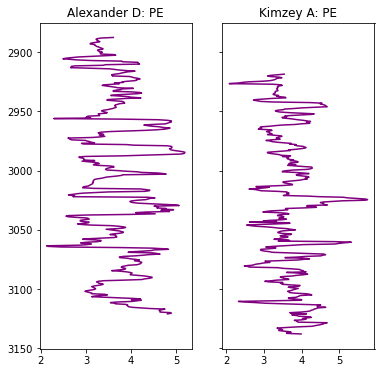

In [46]:
# display the two new PE curves see if they look normal
fig, ax = plt.subplots(1,2,figsize=(6,6), sharey=True)
ax[0].plot(Alex_PE_predict, alexander_d.Depth, color='purple')
ax[1].plot(Kimz_PE_predict, kimzey_a.Depth, color='purple')
ax[0].set_title('Alexander D: PE')
ax[1].set_title('Kimzey A: PE')
ax[0].invert_yaxis()

The two predicted PE curves look good. We can use these new PE curves in the Facies prediction.

In [47]:
# replace the Null data with the predicted PE for both wells
data.loc[data['Well Name']=='ALEXANDER D', 'PE'] = Alex_PE_predict
data.loc[data['Well Name']=='KIMZEY A', 'PE'] = Kimz_PE_predict

In [48]:
alexander_d = data.loc[data['Well Name']=='ALEXANDER D']
kimzey_a = data.loc[data['Well Name']=='KIMZEY A']

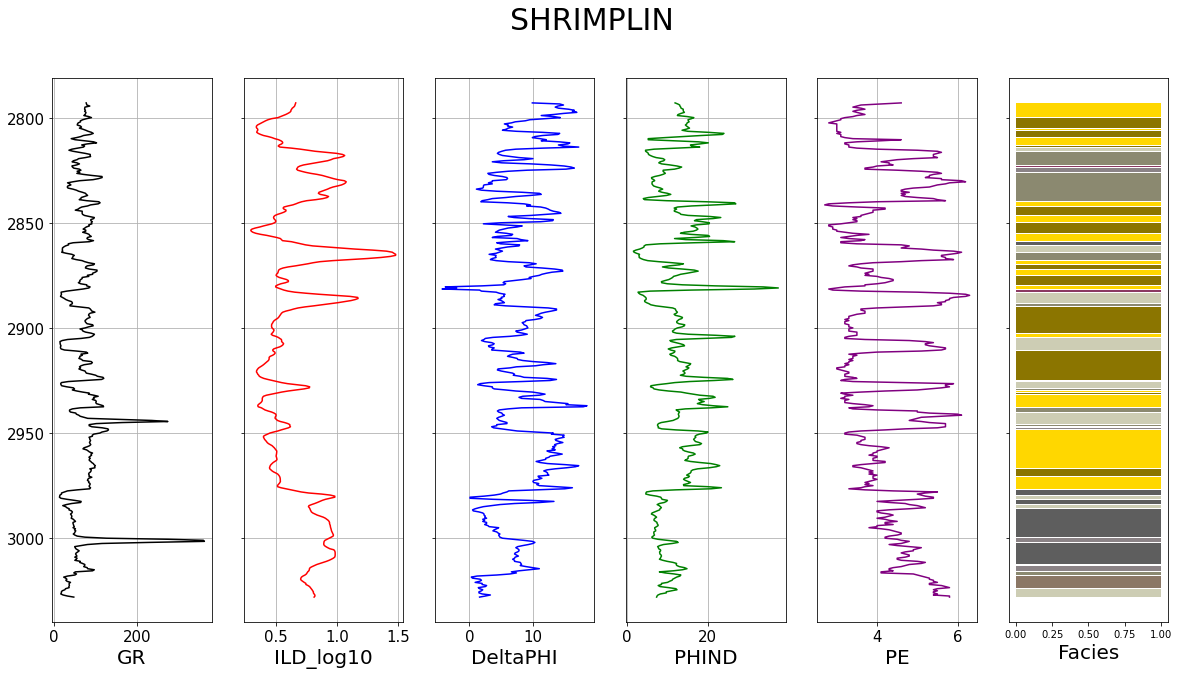

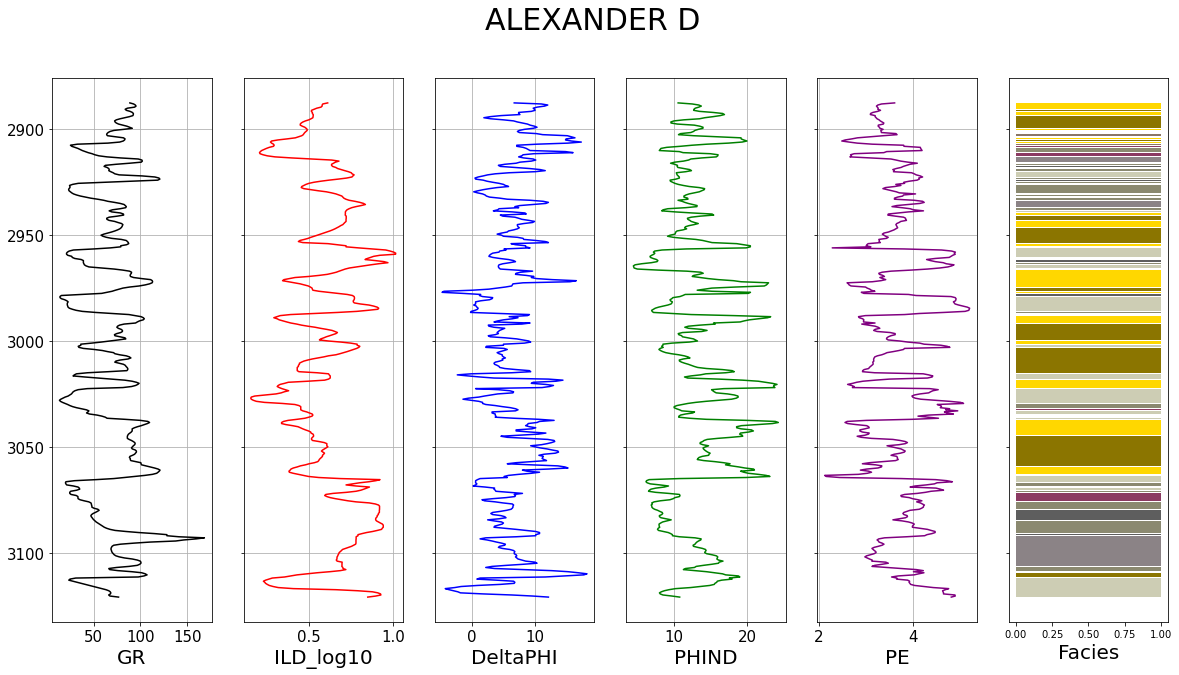

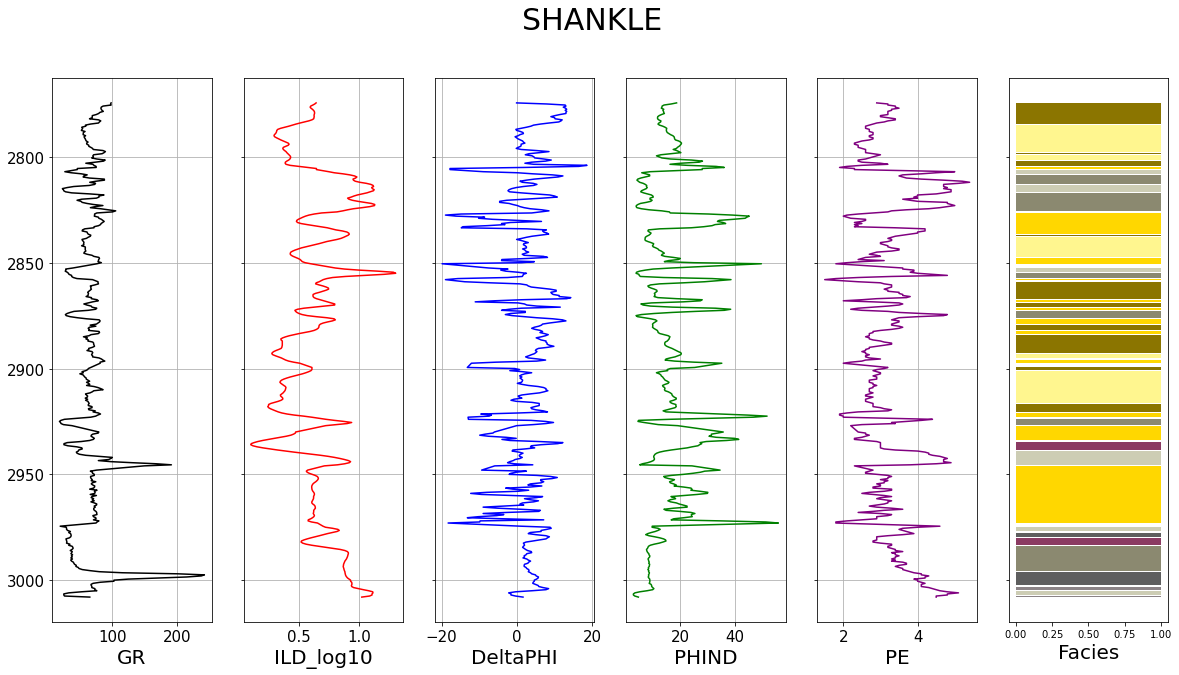

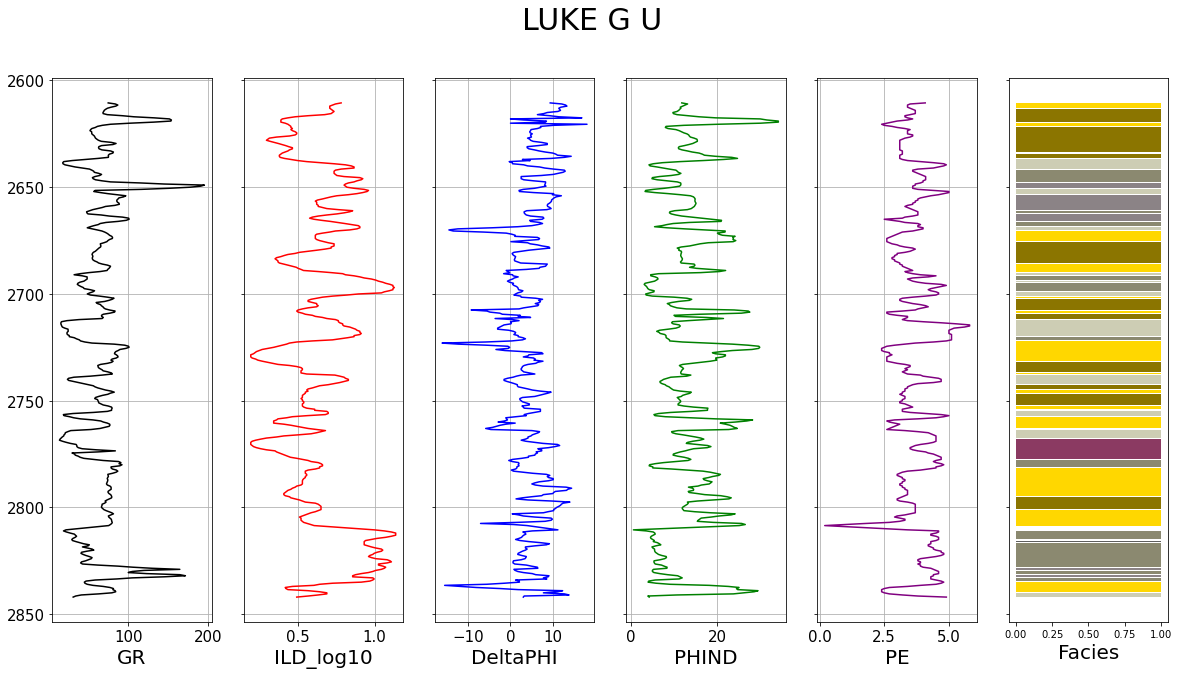

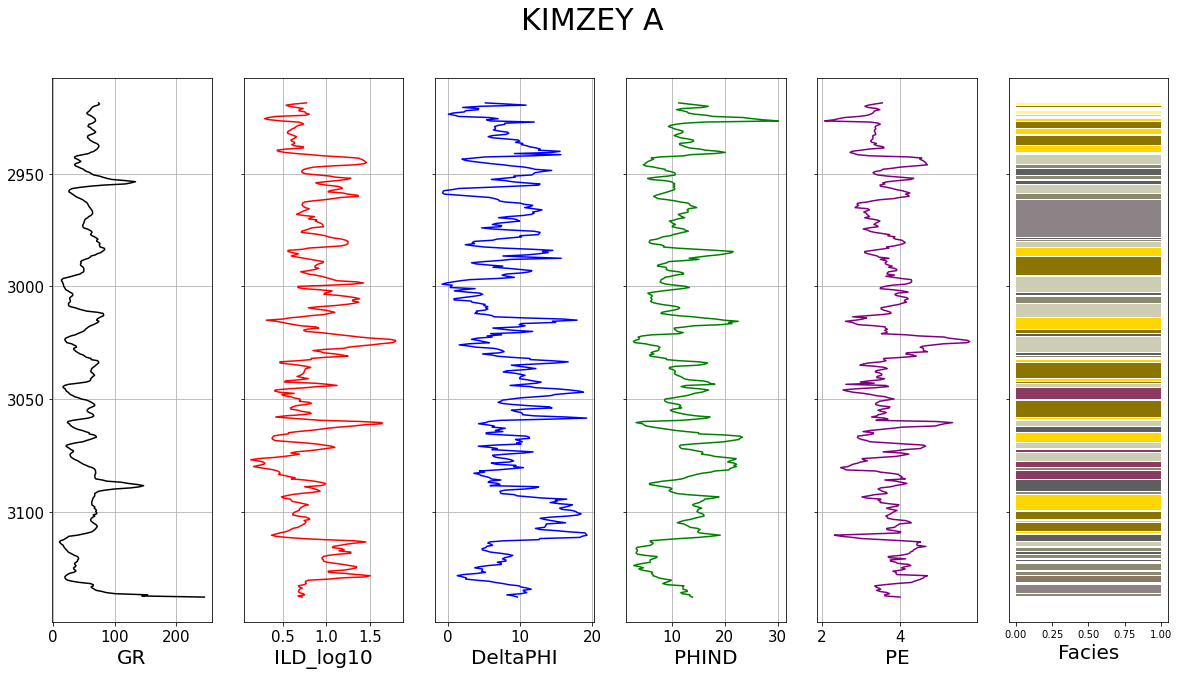

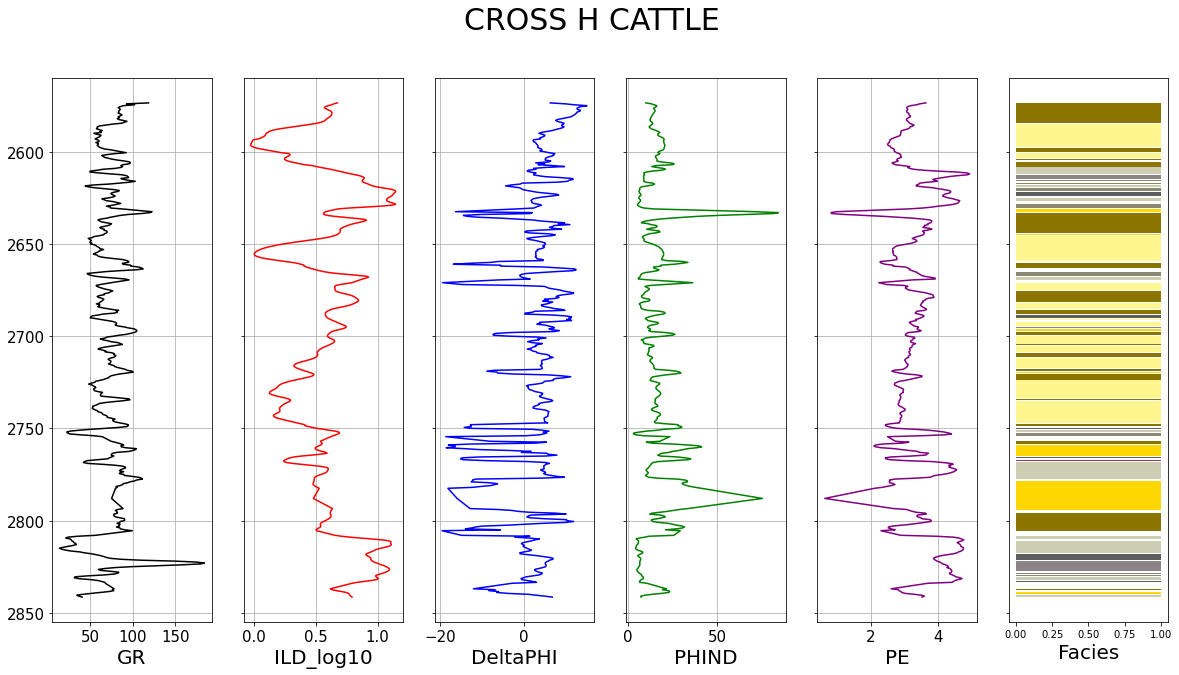

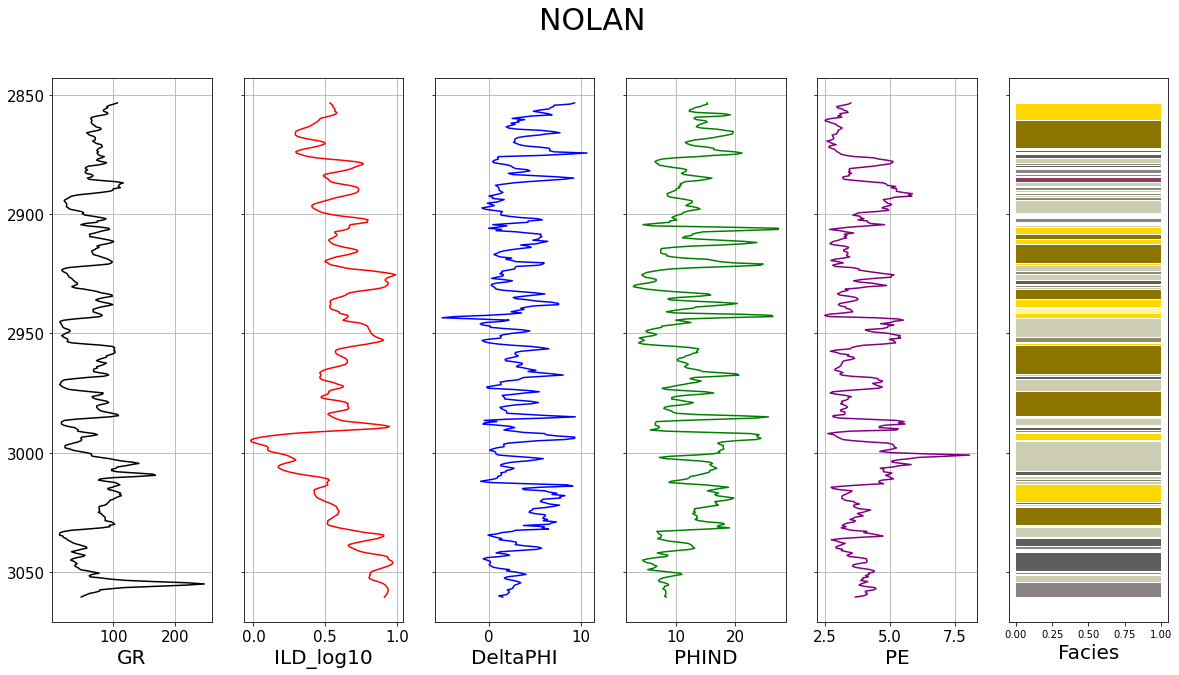

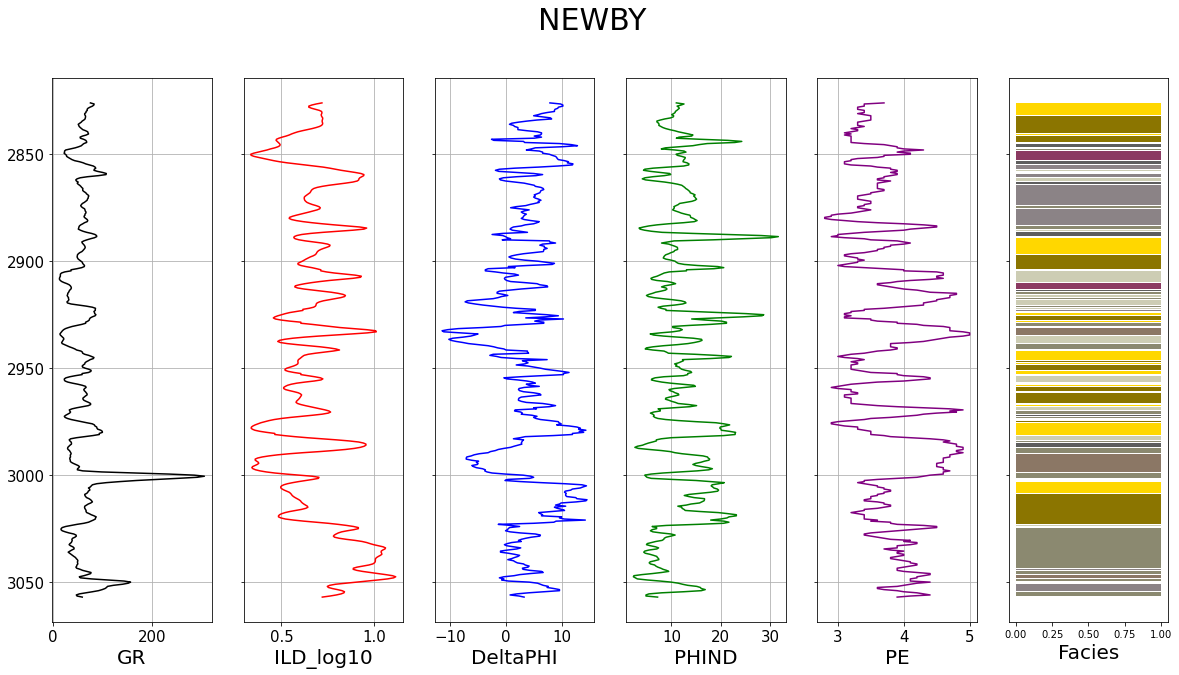

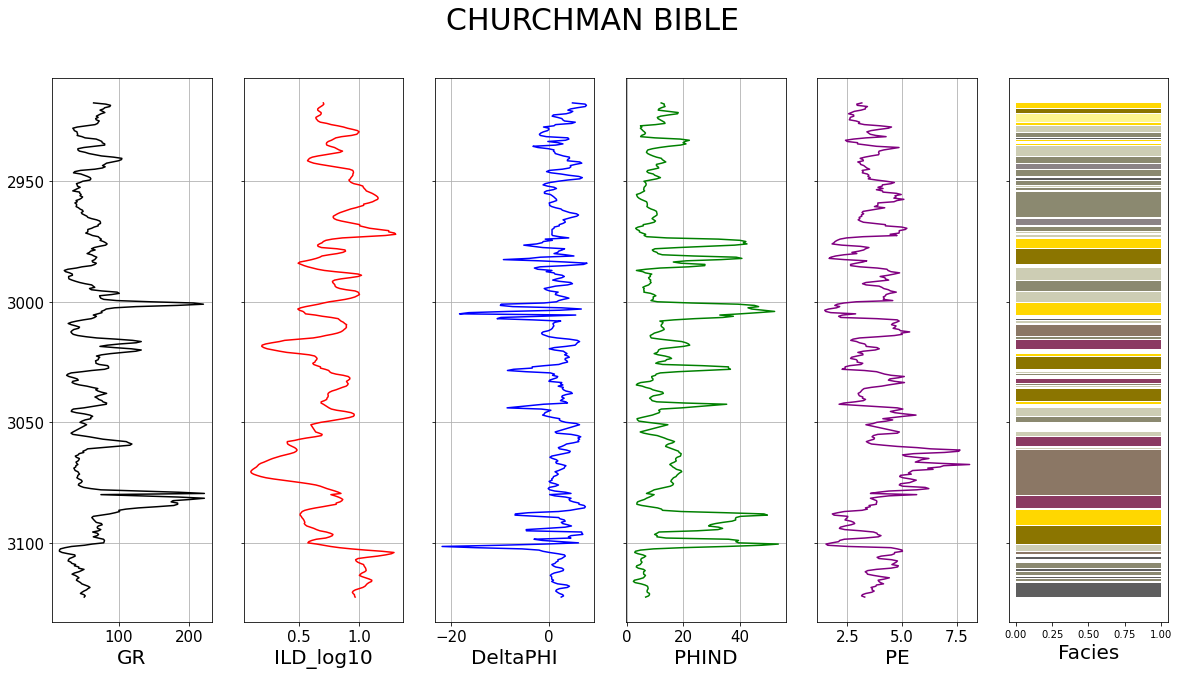

In [49]:
# display logs for each well
dflist = [shrimplin,alexander_d,shankle,luke_g_u,kimzey_a,cross_h_cattle,nolan,newby,churchman_bible]
for df in dflist:
    displayLogs(df, df['Well Name'].unique()[0], log_names, colormap)

## 3 Facies Prediction 